In [161]:
import polars as pl
import networkx as nx
import matplotlib.pyplot as plt
from pyhere import here

In [162]:
DATA = here("data", "interim")

In [163]:
metadata = pl.read_excel(
    here("data", "raw", "metadata.xlsx")
)

In [164]:
data = []
for dpath in DATA.glob("*.csv"):
    d = pl.read_csv(dpath)
    d = d.filter(pl.col("DELAY_MINUTES") > 30)
    data.append(d)

all_data = pl.concat(data)
data_sample = all_data.sample(200)

In [165]:
metadata = metadata.with_columns(
    pl.col("STANOX NO.").cast(int)
)
metadata

STANOX NO.,FULL NAME,CRS CODE,Route Description
i64,str,str,str
87904,"""3BDGS DN TL SDG ENTRY/EXIT""",null,"""Sussex"""
87915,"""3BDGS DOWN THAMESLINK SDGS""",null,"""Sussex"""
87907,"""3 BRIDGES DN DEP SIG TD127""",null,"""Sussex"""
87950,"""3 BRIDGES UP DEP SIG TD165""",null,"""Sussex"""
5,"""AACHEN""",null,"""High Speed"""
…,…,…,…
78362,"""YSTRAD MYNACH""","""YSM""","""TfW Cardiff Valleys"""
78364,"""YSTRAD MYNACH SIG CF7420""",null,"""TfW Cardiff Valleys"""
78363,"""YSTRAD MYNACH SOUTH""",null,"""TfW Cardiff Valleys"""


In [166]:
joined_sample = data_sample
for stnx in ("ORIGIN_STANOX", "DESTINATION_STANOX", "EVENT_STANOX"):
    field = stnx.split("_")[0]
    joined_sample = (
        joined_sample.join(
            metadata.select(["STANOX NO.", "FULL NAME", "CRS CODE"]), 
            left_on=stnx,
            right_on="STANOX NO."
        ).rename(
            {"FULL NAME": field, "CRS CODE": field + "_CODE"}
        )
    )
joined_sample = joined_sample.drop(["ORIGIN_STANOX", "DESTINATION_STANOX", "EVENT_STANOX"])

In [167]:
joined_sample

JOURNEY_ORIGIN_DATETIME,INCIDENT_START_DATETIME,INCIDENT_DURATION,EVENT_DATETIME,DELAY_MINUTES,TOC,INCIDENT_REASON,EVENT_TYPE,ORIGIN,ORIGIN_CODE,DESTINATION,DESTINATION_CODE,EVENT,EVENT_CODE
str,str,str,str,f64,str,str,str,str,str,str,str,str,str
"""2022-09-09 14:00:00""","""2022-09-08 10:30:00""","""0 days 09:26:00""","""2022-09-09 14:00:00""",101.0,"""HA""","""X2""","""C""","""ABERDEEN""","""ABD""","""INVERURIE""","""INR""","""ABERDEEN""","""ABD"""
"""2023-02-11 16:00:00""","""2023-02-11 01:28:00""","""0 days 09:12:00""","""2023-02-11 16:00:00""",101.0,"""HA""","""IR""","""C""","""ABERDEEN""","""ABD""","""INVERURIE""","""INR""","""ABERDEEN""","""ABD"""
"""2022-07-05 12:04:00""","""2022-07-05 11:05:00""","""0 days 08:09:00""","""2022-07-05 13:07:00""",50.5,"""HA""","""MD""","""P""","""MONTROSE""","""MTS""","""INVERURIE""","""INR""","""ABERDEEN""","""ABD"""
"""2022-12-28 06:30:00""","""2022-12-28 05:07:00""","""0 days 08:05:00""","""2022-12-28 06:30:00""",106.0,"""HL""","""MS""","""C""","""ABERYSTWYTH""","""AYW""","""SHREWSBURY""","""SHR""","""ABERYSTWYTH""","""AYW"""
"""2022-05-07 12:44:00""","""2022-05-06 22:00:00""","""0 days 07:59:00""","""2022-05-07 12:44:00""",38.0,"""HA""","""IB""","""C""","""AIRDRIE""","""ADR""","""BALLOCH""","""BHC""","""AIRDRIE""","""ADR"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2023-02-13 10:59:00""","""2023-02-10 19:00:00""","""0 days 13:00:00""","""2023-02-13 11:16:00""",34.0,"""EF""","""JD""","""O""","""GREAT MALVERN""","""GMV""","""LONDON PADDINGTON""","""PAD""","""WORCESTER SHRUB HILL""","""WOS"""
"""2022-07-11 21:00:00""","""2022-07-11 18:52:00""","""0 days 08:21:00""","""2022-07-11 21:04:00""",34.0,"""EF""","""X8""","""O""","""WORCESTER FOREGATE STREET""","""WOF""","""LONDON PADDINGTON""","""PAD""","""WORCESTER SHRUB HILL""","""WOS"""
"""2022-04-20 12:10:00""","""2022-04-20 12:56:00""","""0 days 08:13:00""","""2022-04-20 12:56:00""",41.5,"""ED""","""TG""","""P""","""CARLISLE""","""CAR""","""BARROW-IN-FURNESS""","""BIF""","""WORKINGTON""","""WKG"""


## Graphs



In [179]:
graph = nx.Graph()

In [180]:
unique_destinations = (
    joined_sample
    .select(
        pl.concat_list(["ORIGIN", "DESTINATION"]).explode()
    )
    .to_series().unique().to_list()
)
print(unique_destinations)

['ASCOT', 'SHEERNESS-ON-SEA', 'AIRDRIE', 'CHINGFORD', 'BIRMINGHAM INTERNATIONAL', 'MORECAMBE', 'ALLOA', 'SALISBURY', 'BERWICK-UPON-TWEED', 'BROCKENHURST', 'PETERBOROUGH', 'DOVER PRIORY', 'LLANDUDNO JUNCTION', 'STANSTED AIRPORT', 'ABERDEEN', 'BOURNEMOUTH', 'ELY', 'CARLISLE', 'LLANDUDNO', 'LONDON EUSTON', 'BRADFORD INTERCHANGE', 'BEDFORD', 'LIVERPOOL LIME STREET', 'CHELTENHAM SPA', 'HADFIELD', 'FOUR OAKS', 'WINDSOR & ETON CENTRAL', 'TRURO', 'ENFIELD TOWN', 'NEWTON', 'HASTINGS', 'WINDERMERE', 'GLASGOW CENTRAL', 'CARDIFF QUEEN STREET', 'WIGAN WALLGATE', 'INVERURIE', 'BRISTOL TEMPLE MEADS', 'RUGELEY TRENT VALLEY', 'SOUTHAMPTON CENTRAL', 'STOURBRIDGE TOWN', 'LONDON PADDINGTON', 'STOURBRIDGE JN (TOWN PLAT)', 'CARMARTHEN', 'EAST KILBRIDE', 'DUNDEE', 'BLETCHLEY', 'SITTINGBOURNE', 'PRESTON', 'HUDDERSFIELD', 'SHOTTS', 'LARKHALL', 'MANCHESTER OXFORD ROAD', 'HEXHAM', 'HULL', 'CARDIFF BAY', 'LOOE', 'PENARTH', 'MIDDLESBROUGH', 'WHITBY', 'SUNDERLAND', 'SHREWSBURY', 'BIRMINGHAM NEW STREET', 'DARLINGTON

In [181]:
for dest in unique_destinations:
    graph.add_node(dest)

In [182]:
origin = joined_sample["ORIGIN"].to_list()
destination = joined_sample["DESTINATION"].to_list()

cols = ("DELAY_MINUTES", "TOC", "EVENT_TYPE", "JOURNEY_ORIGIN_DATETIME")
idx = [joined_sample.columns.index(column) for column in cols]
col_to_idx = {c: id for c, id in zip(cols, idx)}

attributes = []
for r in joined_sample.rows():
    attributes.append({col: r[id] for col, id in col_to_idx.items()})

In [183]:
for o, d, attr in zip(origin, destination, attributes):
    graph.add_edge(o, d, **attr)

In [184]:
graph.edges.values()

ValuesView(EdgeView([('ASCOT', 'ALDERSHOT'), ('SHEERNESS-ON-SEA', 'SITTINGBOURNE'), ('AIRDRIE', 'BALLOCH'), ('CHINGFORD', 'LONDON LIVERPOOL STREET'), ('BIRMINGHAM INTERNATIONAL', 'BIRMINGHAM NEW STREET'), ('BIRMINGHAM INTERNATIONAL', 'ABERYSTWYTH'), ('BIRMINGHAM INTERNATIONAL', 'HOLYHEAD'), ('BIRMINGHAM INTERNATIONAL', 'CHESTER'), ('MORECAMBE', 'LANCASTER'), ('ALLOA', 'GLASGOW QUEEN STREET'), ('SALISBURY', 'ROMSEY'), ('SALISBURY', 'READING'), ('SALISBURY', 'BRISTOL TEMPLE MEADS'), ('BERWICK-UPON-TWEED', 'BRISTOL TEMPLE MEADS'), ('BROCKENHURST', 'LYMINGTON PIER'), ('PETERBOROUGH', 'NEWARK NORTH GATE'), ('DOVER PRIORY', 'LONDON VICTORIA'), ('DOVER PRIORY', 'ST PANCRAS INTL (DOMESTIC)'), ('LLANDUDNO JUNCTION', 'LLANDUDNO'), ('STANSTED AIRPORT', 'BIRMINGHAM NEW STREET'), ('ABERDEEN', 'INVERURIE'), ('BOURNEMOUTH', 'MANCHESTER PICCADILLY'), ('BOURNEMOUTH', 'POOLE'), ('ELY', 'LONDON KINGS CROSS'), ('CARLISLE', 'BARROW-IN-FURNESS'), ('CARLISLE', 'LEEDS'), ('CARLISLE', 'WHITEHAVEN'), ('LLANDUDN

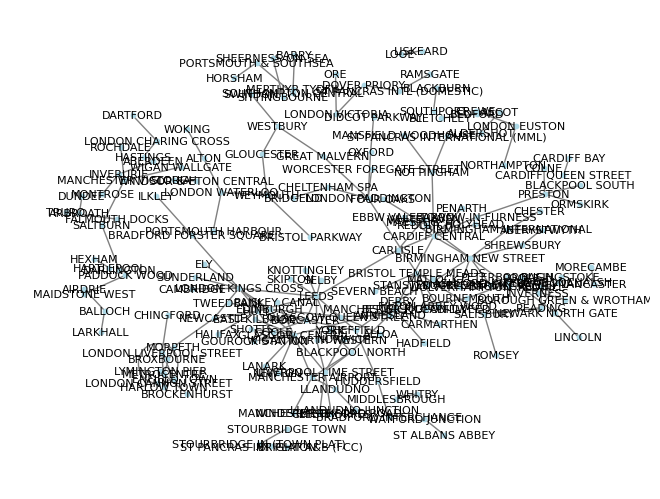

In [ ]:
pos = nx.spring_layout(graph, k=0.2)  # positions for all nodes
nx.draw(
    graph, 
    pos, 
    with_labels=True, 
    node_color='lightblue', 
    edge_color='gray', 
    node_size=10, 
    font_size=8
)
plt.show()